In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Import Data
- Getting Data
- Unzip data

In [2]:
! wget -P ../../data/raw https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

--2020-10-22 15:55:25--  https://www.kaggle.com/becksddf/churn-in-telecoms-dataset
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘../../data/raw/churn-in-telecoms-dataset.8’

churn-in-telecoms-d     [ <=>                ]  50.11K  --.-KB/s    in 0.03s   

2020-10-22 15:55:25 (1.68 MB/s) - ‘../../data/raw/churn-in-telecoms-dataset.8’ saved [51314]



In [3]:
! unzip -o ../../data/raw/"bigml_59c28831336c6604c800002a.csv.zip"

unzip:  cannot find or open ../../data/raw/bigml_59c28831336c6604c800002a.csv.zip, ../../data/raw/bigml_59c28831336c6604c800002a.csv.zip.zip or ../../data/raw/bigml_59c28831336c6604c800002a.csv.zip.ZIP.


---

# Understanding of Data and Business Question.

In this dat set, SyriaTel company has data about their Customers such as how much they use, what plan they have and more importantly how many left their plan, and how many stayed in thier business.

in this data set, churn customers are marked as positiver or 1, and stayed( current) customers negative or 0. What they want from this data set is to predict customers who are going to leave the plan, and keep this number as low as possible. 

The prediction of this data set is:
- True Negative (TN) == False, meaning of stayed custmoers
- True Positive (TP) == True, meaning of left customers
- False Negative (FN) == False, predicted stayed meaning of customers already left
- False Positive (FP) == False, predicted left meaning of customers stayed 

What we want to reduce here is FN, and with the lower FN we can have the most accurate number on TN which is stayed customers. 

# Making Data Frame and Cleaning Data

In [4]:
df = pd.read_csv('../../data/raw/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df['churn'] = df['churn'].astype(int)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


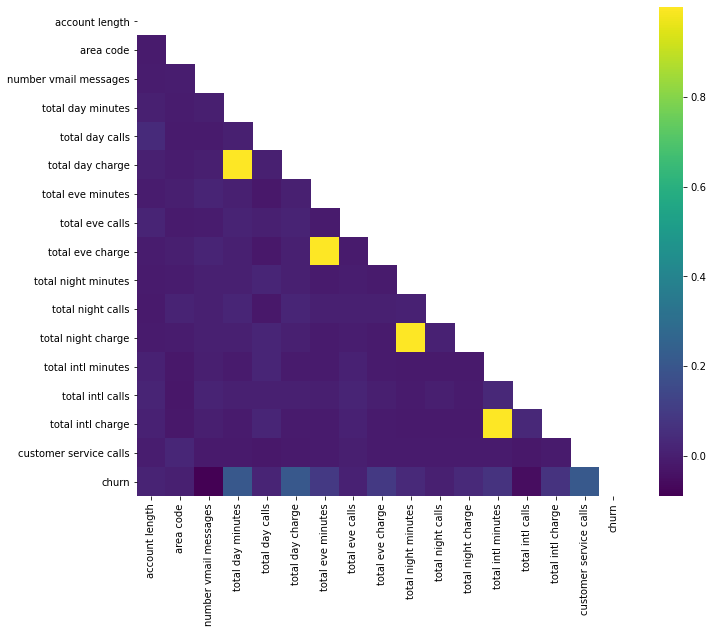

In [6]:
corr = df.corr()
# The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

In [7]:
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [8]:
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [9]:
df.duplicated().value_counts()

False    3333
dtype: int64

In [10]:
df['churn'] = df['churn'].astype(int)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


## Making Target


In [11]:
df.churn.value_counts()
X= df.drop('churn', axis=1)
y = df.churn

In [12]:
X.dtypes.value_counts()

float64    8
int64      8
object     4
dtype: int64

## Train Test Split


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
print(X_train.shape)
print(y_train.shape)

(2666, 20)
(2666,)


In [14]:
X_train.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls'],
      dtype='object')

In [15]:
X_tr_num = X_train.drop(['state', 'area code', 'phone number', 'international plan', 'voice mail plan'], axis=1)
X_tr_num

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,243,0,95.5,92,16.24,163.7,63,13.91,264.2,118,11.89,6.6,6,1.78,2
1373,108,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4
679,75,0,222.4,78,37.81,327.0,111,27.80,208.0,104,9.36,8.7,9,2.35,1
56,141,0,126.9,98,21.57,180.0,62,15.30,140.8,128,6.34,8.0,2,2.16,1
1993,86,0,216.3,96,36.77,266.3,77,22.64,214.0,110,9.63,4.5,3,1.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,0,274.4,120,46.65,198.6,82,16.88,160.8,62,7.24,6.0,3,1.62,1
1130,122,0,35.1,62,5.97,180.8,89,15.37,251.6,58,11.32,12.7,2,3.43,1
1294,66,0,87.6,76,14.89,262.0,111,22.27,184.6,125,8.31,9.2,5,2.48,1
860,169,0,179.2,111,30.46,175.2,130,14.89,228.6,92,10.29,9.9,6,2.67,2


## Dealing with Categorical Columns 


In [16]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_tr_cat = X_train[['state', 'area code', 'international plan', 'voice mail plan']]

X_tr_oh = pd.DataFrame(ohe.fit_transform(X_tr_cat), columns=ohe.get_feature_names(X_tr_cat.columns), index=X_tr_cat.index)
X_tr_ = X_tr_num.join(X_tr_oh)
X_tr_

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
817,243,0,95.5,92,16.24,163.7,63,13.91,264.2,118,11.89,6.6,6,1.78,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1373,108,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
679,75,0,222.4,78,37.81,327.0,111,27.80,208.0,104,9.36,8.7,9,2.35,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
56,141,0,126.9,98,21.57,180.0,62,15.30,140.8,128,6.34,8.0,2,2.16,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1993,86,0,216.3,96,36.77,266.3,77,22.64,214.0,110,9.63,4.5,3,1.22,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,0,274.4,120,46.65,198.6,82,16.88,160.8,62,7.24,6.0,3,1.62,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1130,122,0,35.1,62,5.97,180.8,89,15.37,251.6,58,11.32,12.7,2,3.43,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1294,66,0,87.6,76,14.89,262.0,111,22.27,184.6,125,8.31,9.2,5,2.48,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
860,169,0,179.2,111,30.46,175.2,130,14.89,228.6,92,10.29,9.9,6,2.67,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Scaling Data 


In [17]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_tr_), index=X_tr_.index, columns=X_tr_.columns)
X_train_sc

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
817,3.601382,-0.584936,-1.547653,-0.429657,-1.547170,-0.729987,-1.840891,-0.731087,1.255804,0.925634,1.256197,-1.300791,0.634849,-1.304132,0.318978,-0.128037,-0.154303,-0.124976,-0.142419,-0.101149,-0.147809,-0.151736,-0.124976,-0.139653,-0.13825,-0.128037,-0.133962,-0.120248,-0.146478,-0.129542,-0.141042,-0.142419,-0.133962,-0.129542,-0.143784,-0.150437,-0.135405,-0.151736,-0.163,-0.141042,-0.132504,-0.145137,-0.142419,-0.135405,-0.121843,-0.124976,-0.142419,-0.141042,-0.141042,-0.158083,-0.160559,-0.136835,-0.150437,-0.115338,-0.143784,-0.133962,-0.141042,-0.129542,-0.150437,6.705633,-0.154303,-0.145137,-0.147809,-0.161784,-0.180369,-0.153025,-0.584569,-0.994016,1.739882,0.326624,-0.326624,0.611162,-0.611162
1373,0.184951,-0.584936,-1.244014,0.224176,-1.244071,-0.138082,0.499864,-0.139179,0.165090,-0.353704,0.164841,-2.194793,-0.184370,-2.191525,1.813519,-0.128037,-0.154303,-0.124976,-0.142419,-0.101149,-0.147809,-0.151736,-0.124976,-0.139653,-0.13825,-0.128037,-0.133962,-0.120248,-0.146478,-0.129542,-0.141042,-0.142419,-0.133962,-0.129542,-0.143784,-0.150437,-0.135405,-0.151736,-0.163,-0.141042,-0.132504,-0.145137,-0.142419,-0.135405,-0.121843,-0.124976,-0.142419,-0.141042,-0.141042,-0.158083,-0.160559,-0.136835,-0.150437,-0.115338,-0.143784,7.464811,-0.141042,-0.129542,-0.150437,-0.149128,-0.154303,-0.145137,-0.147809,-0.161784,-0.180369,-0.153025,-0.584569,1.006020,-0.574752,0.326624,-0.326624,0.611162,-0.611162
679,-0.650176,-0.584936,0.787609,-1.133785,0.787772,2.491952,0.549667,2.493068,0.147339,0.209205,0.147309,-0.549828,1.863677,-0.549186,-0.428293,-0.128037,-0.154303,-0.124976,-0.142419,-0.101149,-0.147809,-0.151736,-0.124976,-0.139653,-0.13825,-0.128037,-0.133962,-0.120248,-0.146478,-0.129542,-0.141042,-0.142419,-0.133962,-0.129542,-0.143784,-0.150437,-0.135405,-0.151736,-0.163,-0.141042,-0.132504,-0.145137,-0.142419,-0.135405,-0.121843,-0.124976,-0.142419,-0.141042,-0.141042,-0.158083,-0.160559,-0.136835,-0.150437,-0.115338,-0.143784,-0.133962,-0.141042,-0.129542,6.647288,-0.149128,-0.154303,-0.145137,-0.147809,-0.161784,-0.180369,-0.153025,-0.584569,1.006020,-0.574752,-3.061624,3.061624,0.611162,-0.611162
56,1.020079,-0.584936,-0.969818,-0.127888,-0.970200,-0.408385,-1.890695,-0.408439,-1.178086,1.437368,-1.176344,-0.800149,-1.003589,-0.800835,-0.428293,-0.128037,-0.154303,-0.124976,-0.142419,-0.101149,6.765496,-0.151736,-0.124976,-0.139653,-0.13825,-0.128037,-0.133962,-0.120248,-0.146478,-0.129542,-0.141042,-0.142419,-0.133962,-0.129542,-0.143784,-0.150437,-0.135405,-0.151736,-0.163,-0.141042,-0.132504,-0.145137,-0.142419,-0.135405,-0.121843,-0.124976,-0.142419,-0.141042,-0.141042,-0.158083,-0.160559,-0.136835,-0.150437,-0.115338,-0.143784,-0.133962,-0.141042,-0.129542,-0.150437,-0.149128,-0.154303,-0.145137,-0.147809,-0.161784,-0.180369,-0.153025,-0.584569,1.006020,-0.574752,0.326624,-0.326624,0.611162,-0.611162
1993,-0.371801,-0.584936,0.675354,-0.228477,0.675192,1.294330,-1.143645,1.295326,0.265680,0.516246,0.265649,-2.051753,-0.593980,-2.045833,-1.175564,-0.128037,-0.154303,-0.124976,-0.142419,-0.101149,-0.147809,-0.151736,-0.124976,-0.139653,-0.13825,-0.128037,-0.

## Smote Imbalance Data

In [18]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train_sc, y_train.ravel())

---

# Modeling

## RandomForst Model

In [19]:
rf1 = RandomForestClassifier(max_depth=2, random_state=0)
rf1.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=2, random_state=0)